# CNN Model

#### Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import regularizers
import tensorflow_model_optimization as tfmot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from IPython.display import display, Image
from tensorflow_addons.metrics import F1Score

#### GPU deaktivieren

**Hinweis:** Bei M1/M2-Chips wird standardmäßig die GPU verwendet. Daher muss es für diese Chips einkommentiert werden, da diese Dropout-Layer mit GPU nicht gut handeln können

In [18]:
tf.config.set_visible_devices([], 'GPU')

#### Daten einlesen

**Hinweis:** Die Daten wurden in einer pkl-Datei gespeichert, um nicht jedes mal die Vorverarbeitung durchführen zu müssen und unkompliziert zwischen den Modelklassen hin- und her wechseln zu können

In [19]:
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size
num_samples = len(data)
class_dist = data['Species'].value_counts()
X, y = data['data'], data['Species']
# Wir hatten massive Probleme mit der Begrenztheit unseres RAMs, weshalb wir versucht haben die Usage an mehreren Stellen zu reduzieren
X, y = np.stack(X).astype(np.float16), y.to_numpy().astype(np.uint8)

#### Seed setzen

Um die Nachvollziehbarkeit zu erhöhen setzen wir den Seed immer auf den selben Startwert

In [20]:
tf.keras.utils.set_random_seed(1)

Bei Verwendung einer GPU macht es die Operationen so deterministisch wie möglich

**Hinweis:** Diese Option vermindert die Performance

In [21]:
tf.config.experimental.enable_op_determinism()

#### Bilder reshapen

In [22]:
image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # Shape der Bilder nach dem resizen aus dem data_prep notebook
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c'])

In [23]:
X = X.reshape((-1,) + image_shape)
print(f"Image has shape: {image_shape}")

Image has shape: (82, 128, 3)


#### k-Fold-Cross-Validation

Wir benutzen 10-Fold-Cross-Validation, um das Ergebnis weniger vom gewählten Split abhängig zu machen und somit das Ergebnis zu stabilisieren. Statified stellt sicher, dass die Klasseneinteilung beibehalten wird. Dies ist vor allem ohne Resampling interessant, da wir extrem ungleich verteilte Klassen haben.

In [24]:
kfold = StratifiedKFold(n_splits=2, shuffle=True)

#### Modell

Bei den Hyperparametern haben wir Grundsätzlich Standardwerte aus Papern o. Ä. benutzt und dann je nach Ergebnis empirisch angepasst (Versuchte Parameter haben wir mal weggelassen, aber wir haben alle möglichen Kernelsizes, Neuronenanzahlen, usw. probiert)

[Modelstruktur](https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn)  
[Epochs](https://doi.org/10.1016/j.icte.2020.04.010)  
[Batch-Size und Learning Rate](https://elar.khmnu.edu.ua/items/a5d0d900-449d-4f3d-b800-c7200084384f)  
[Dropout-Rate](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)  
[Pooling-Size](https://cs231n.github.io/convolutional-networks/#pool)  
Weigh_decay_alpha: aus der Vorlesung
Padding: Wir wollen nicht, dass für jede Schicht das Bild kleiner wird, da sonst das Innere des Bildes viel stärker gewichtet werden würde
Batch Normalization: Normalisiert die Daten nach jedem Layer
Relu: Da es sich um Bilder handelt und sie somit nur im positiven Wertebereich sind

In [25]:
f1 = F1Score(num_classes=number_of_classes, average="micro")

In [26]:
# Stoppt wenn bei 30 Epochen die Validation-Accuracy nicht um mehr als 0.01 besser wird
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.01, start_from_epoch=15, restore_best_weights=True)
epochs = 200
batch_size = 32
dropout_rate = 0.2
weight_decay_alpha = 0.01

def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=image_shape, name="aaa"))
    model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(number_of_classes, activation='softmax'))

    return model

#### Optimizierwahl

Wir haben verschiedene Optimizier mit und ohne ExpoentialLRDecay ausprobiert (es wurde auch adagrad getestet, aber schnell verworfen, da es extrem schlecht war):

|Optimizer|Avg. Test Acc|
|:-|-:|
|**SGD**| 77% |
|**SGD_exp**| 72% |
|**ADAM**|79%|
|**ADAM_exp**| 74% |

In [27]:
def create_optimizers(num_samples) -> dict:
    s = 130 * num_samples // 32 # number of steps in 130 epochs (batch size = 32)
    exp_decay_sgd = ExponentialDecay(0.01, s, 0.1)
    exp_adam = ExponentialDecay(0.01, s, 0.95, staircase=True)

    momentum = 0.99
    sgd_exp = SGD(exp_decay_sgd, momentum=momentum)
    adam_exp = Adam(exp_adam)

    sgd = SGD(0.001, momentum=momentum)
    adam = Adam(0.001)

    return {"sgd_exp": sgd_exp, "adam_exp": adam_exp, "sgd": sgd, "adam": adam}

#### Model Fit Funktion

In [28]:
def fit_model(model, X_train, y_train, X_val=None, y_val=None, class_weights=(class_dist / class_dist).to_dict()):
    # Das Model macht selbst den Validation Split
    if X_val is None or y_val is None:
        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, tfmot.sparsity.keras.UpdatePruningStep()],
            validation_split=0.2,
            verbose=1,
            class_weight=class_weights)
    # Wir übergeben dem Model Validation Daten
    elif X_val is not None and y_val is not None:
        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, tfmot.sparsity.keras.UpdatePruningStep()],
            validation_data=(X_val,y_val),
            verbose=1,
            class_weight=class_weights)
    return history

#### Model Pruning

Größtenteils von hier übernommen und hat gut funktioniert: https://towardsdatascience.com/model-pruning-in-deep-neural-networks-using-the-tensorflow-api-7cf52bdd32

In [29]:
end_step = np.ceil(X.shape[0] / batch_size).astype(np.int32) * epochs

pruning_params = {
      # Inital: 50% sparsity (50% zeros in weights) und Final: 80% Sparsity
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=0.80,
                                                                begin_step=0,
                                                                end_step=end_step)}

model = create_model()
model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

#### Split-Funktion

In [30]:
def train_val_test_split(train_indezes, test_indezes):
    X_train, X_val, y_train, y_val = train_test_split(X[train_indezes], y[train_indezes], test_size=0.2,stratify=y[train_indezes], random_state=42)
    X_test, y_test = X[test_indezes], y[test_indezes]
    
    # Das speichern als Tensor spart RAM
    return (tf.convert_to_tensor(X_train),
            tf.convert_to_tensor(y_train), 
            tf.convert_to_tensor(X_val),
            tf.convert_to_tensor(y_val),
            tf.convert_to_tensor(X_test),
            tf.convert_to_tensor(y_test))

#### Weighted loss function

Wir haben uns auch überlegt die loss_function zu gewichten, um die ungleiche Klassenverteilung ein wenig abzuschwächen. Leider hatten wir nicht mehr genug Zeit gute Gewichtungen zu finden. Man sieht das die kleineren Klassen deutlich besser predicted werden, aber die größeren dafür schlechter. Wenn man einen guten Tradeoff finden würde, würde man wahrscheinlich ein besseres Ergebnis als ohne erhalten.

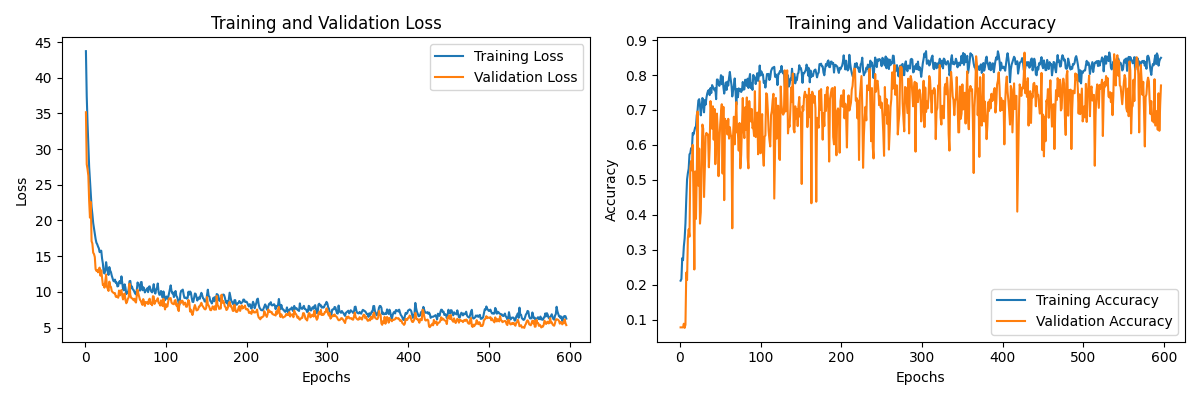

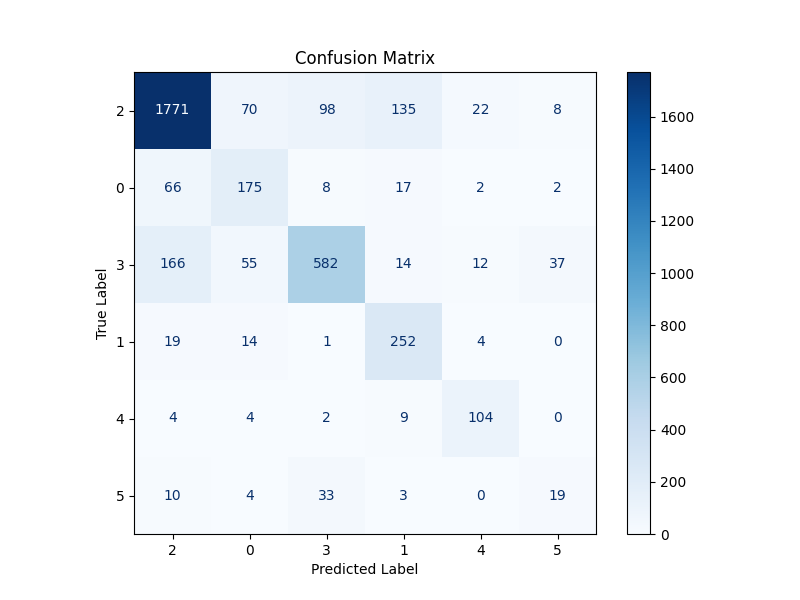

'Avg. Val Accuracy: 0.6918987284395719\nBest Val Accuracy: 0.8641790747642517\nAvg. Test Accuracy: 0.7799850165843963\nBest Test Accuracy: 0.8306451439857483\nAvg. Test Loss: 6.546444940567016'

In [31]:
# Kleine Klassen stärken
class_weights_inv = (1.0 / (class_dist / num_samples)).to_dict()

display(Image(filename="weighted_inv_curves.png"))
display(Image(filename="weighted_inv_matrix.png"))

"""Avg. Val Accuracy: 0.6918987284395719
Best Val Accuracy: 0.8641790747642517
Avg. Test Accuracy: 0.7799850165843963
Best Test Accuracy: 0.8306451439857483
Avg. Test Loss: 6.546444940567016"""

#### Tatsächliches Training

In [32]:
# Abspeichern der Erebnisse jedes Splits für die Confusion-Matrix
true_labels = list()
pred_labels = list()
train_accuracies = list()
test_accuracies = list()
val_accuracies = list()
train_losses = list()
val_losses = list()
test_losses = list()

split_count = 1
for train_indezes, test_indezes in kfold.split(X, y):
    print(f"Current Split: {split_count}")
    # wir löschen das Model der letzten Iteration aus dem Cache um RAM zu sparen
    K.clear_session()

    # Daten splitten
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(train_indezes, test_indezes)

    # Resample nur Trainings- und Validationmenge
    #X_train, y_train = resample_after_split(X_train, y_train)
    #X_val, y_val = resample_after_split(X_val, y_val)

    optimizers = create_optimizers(len(X_train))
    
    # Das Model wird hier compiled, damit wir nach jeder Iteration das alte Model aus dem Cache löschen können  Adam(0.001)
    model.compile(optimizer=optimizers['adam'], loss="sparse_categorical_crossentropy", metrics=[f1])#["accuracy"])
    history = fit_model(model, X_train, y_train, X_val, y_val)#, class_weights_inv)

    # Für die Confusion Matrix
    predictions = np.argmax(model.predict(X_test), axis=-1)
    true_labels.extend(y_test)
    pred_labels.extend(predictions)

    # Für die Accuracy-Curves
    train_accuracies.extend(history.history['accuracy'])
    val_accuracies.extend(history.history['val_accuracy'])

    # Für die Loss-Curves
    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])

    loss, accuracy = model.evaluate(X_test, y_test)
    test_accuracies.append(accuracy)
    test_losses.append(loss)

    split_count += 1

Current Split: 1
Epoch 1/200
47/47 [==============================] - 12s 130ms/step - loss: 31.8983 - f1_score: 0.2856 - val_loss: 29.2162 - val_f1_score: 0.2855
Epoch 2/200
47/47 [==============================] - 6s 119ms/step - loss: 24.7951 - f1_score: 0.2856 - val_loss: 21.7497 - val_f1_score: 0.2855
Epoch 3/200
47/47 [==============================] - 7s 146ms/step - loss: 16.6915 - f1_score: 0.2856 - val_loss: 14.5091 - val_f1_score: 0.2855
Epoch 4/200
47/47 [==============================] - 6s 133ms/step - loss: 12.2891 - f1_score: 0.2856 - val_loss: 11.1646 - val_f1_score: 0.2855
Epoch 5/200
47/47 [==============================] - 7s 147ms/step - loss: 9.6858 - f1_score: 0.2856 - val_loss: 9.1193 - val_f1_score: 0.2855
Epoch 6/200
47/47 [==============================] - 6s 128ms/step - loss: 7.8393 - f1_score: 0.2856 - val_loss: 7.5904 - val_f1_score: 0.2855
Epoch 7/200
47/47 [==============================] - 8s 163ms/step - loss: 6.5276 - f1_score: 0.2856 - val_loss: 6.8

KeyboardInterrupt: 

#### VGG19 und ResNet50 als Vergleich

**Hinweis:** Um die Lesbarkeit zu verbessern stehen die beiden Modelle in eigenen Stellen. Natürlich wäre das Ergebnis noch ein klein bisschen aussagekräftiger, weniger rechenintensiv und RAM sparrender, wenn wir die Splits unseres eigenen Models wiederverwenden würden. Außerdem trainieren wir die Conv-Layer nicht nach, da wir nur einen groben Anhaltspunkt haben wollten und durch die begrenzte Rechenkapazität uns lieber auf einen Erkenntnisgewinn in unseren Nachforschungen fokusieren wollten.

##### VGG19

In [ ]:
%%script false --no-raise-error
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
epochs = 200
batch_size = 32

vgg19_test_accuracies = list()

base_model = VGG19(weights='imagenet', include_top=False, input_shape=image_shape)

# Convolution-Teil fixieren
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

for train_indezes, test_indezes in kfold.split(X, y):
    K.clear_session()
    X_train, y_train = tf.convert_to_tensor(X[train_indezes]), tf.convert_to_tensor(y[train_indezes])
    X_test, y_test = tf.convert_to_tensor(X[test_indezes]), tf.convert_to_tensor(y[test_indezes])
    history = model.fit(X_train, y_train, batch_size=batch_size, callbacks=[early_stopping], epochs=epochs, validation_split=0.2, verbose=1)
    _, accuracy = model.evaluate(X_test, y_test)
    vgg19_test_accuracies.append(accuracy)

##### ResNet50

In [ ]:
%%script false --no-raise-error
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
epochs = 200
batch_size = 32

resnet50_test_accuracies = list()

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)

# Convolution-Teil fixieren
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.layers.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

for train_indezes, test_indezes in kfold.split(X, y):
    K.clear_session()
    X_train, y_train = tf.convert_to_tensor(X[train_indezes]), tf.convert_to_tensor(y[train_indezes])
    X_test, y_test = tf.convert_to_tensor(X[test_indezes]), tf.convert_to_tensor(y[test_indezes])
    history = model.fit(X_train, y_train, batch_size=batch_size, callbacks=[early_stopping], epochs=epochs, validation_split=0.2, verbose=1)
    _, accuracy = model.evaluate(X_test, y_test)
    resnet50_test_accuracies.append(accuracy)

#### Confusion Matrix

Man kann klar erkennen, je weniger Datenpunkte vorhanden desto schlechter ist die Klassifikation. Leider konnten wir, wie bereits erwähnt ohne Domänenwissen und den eingeschränkten Mitteln das Problem nicht lösen.

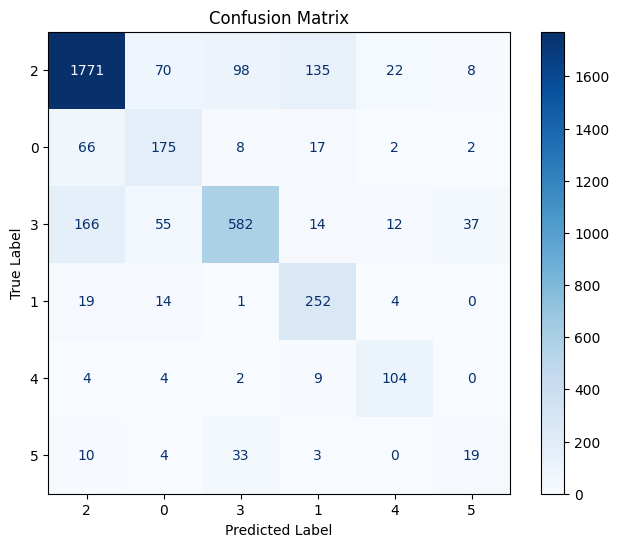

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(cm, display_labels=classes)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("./cnn_files/confusion_matrix.png")
plt.show()

#### Trainings- und Validationkurve plotten

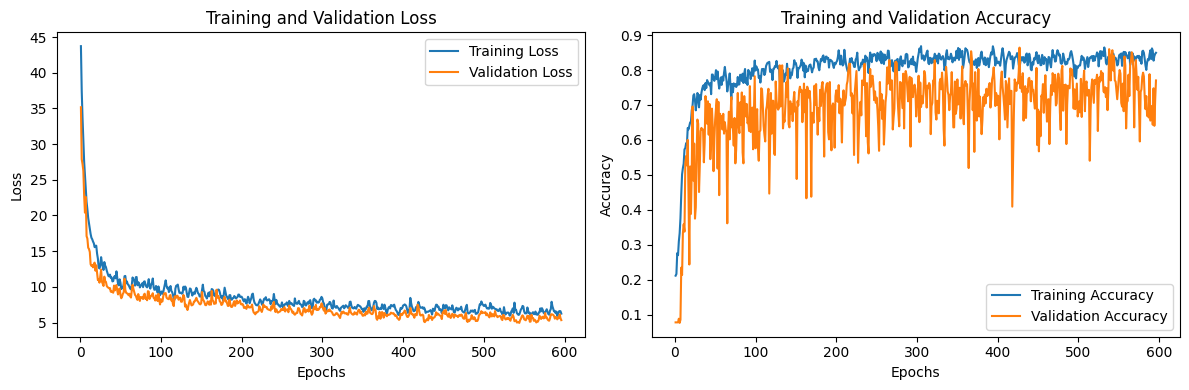

In [ ]:
epochs = len(train_losses)
plt.figure(figsize=(12, 4))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("./cnn_files/loss_and_accuraccy.png")
plt.show()

#### Ergebnisse

|Durchführung|Avg. Test Acc|
|:-|-:|
|**VGG19**|
| Kein Resample, top 6 classes (> 60), vgg19| 82% |
| Kein Resample, top 4 classes (>200), vgg19| 83% |
| Kein Resample, top 2 classes (>500), vgg19| 91% |
|---------------|
|**ResNet50**|
| Kein Resample, top 6 classes (> 60), resNet50| 70% |
| Kein Resample, top 4 classes (>200), resNet50| 74% |
| Kein Resample, top 2 classes (>500), resNet50| 84% |
|---------------|
|**Unser Modell**|
| Kein Resample, top 6 classes (> 60), cnn  | 79% |
| Kein Resample, top 4 classes (>200), cnn  | 83% |
| Kein Resample, top 2 classes (>500), cnn  | 87% |

In [ ]:
#print(f"VGG19 Avg. test accuracy: {sum(vgg19_test_accuracies) / len(vgg19_test_accuracies)}")
#print(f"ResNet50 Avg. test accuracy: {sum(vgg19_test_accuracies) / len(vgg19_test_accuracies)}")

print("Unser Modell:")
print(f"Avg. Val Accuracy: {sum(val_accuracies) / len(val_accuracies)}")
print(f"Best Val Accuracy: {max(val_accuracies)}")
print(f"Avg. Test Accuracy: {sum(test_accuracies) / len(test_accuracies)}")
print(f"Best Test Accuracy: {max(test_accuracies)}")
print(f"Avg. Test Loss: {sum(test_losses) / len(test_losses)}")

Unser Modell:
Avg. Val Accuracy: 0.6918987284395719
Best Val Accuracy: 0.8641790747642517
Avg. Test Accuracy: 0.7799850165843963
Best Test Accuracy: 0.8306451439857483
Avg. Test Loss: 6.546444940567016
